<a href="https://colab.research.google.com/github/nataliaespector/CEIA_TPs_Procesamiento_Lenguaje_Natural_1/blob/main/Espector_PLN_Desafio_3_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [170]:
import random
import io
import pickle

import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from scipy.special import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset el libro "Cinco Semanas en Globo" de Julio Verne.

In [171]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [172]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/cinco-semanas-en-globo/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [173]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' el final de un discurso muy\r\naplaudido. —\r\npresentación del doctor samuel fergusson. —\r\n" excelsior. " — retrato de cuerpo entero del doctor. —\r\nun fatalista convencido. — comida en el traveller\'s club. —\r\nnumerosos brindis de circunstancias el día 14 de enero de 1862 había asistido un numeroso auditorio\r\na la sesión de la real sociedad geográfica de londres, plaza de\r\nwaterloo, 3. el presidente, sir francis m … . comunicaba a sus\r\nilustres colegas un hecho importante en un discurso frecuentemente\r\ninterrumpido por los aplausos. aquella notable muestra de elocuencia finalizaba con unas\r\ncuantas frases rimbombantes en las que el patriotismo manaba a\r\nborbotones: "inglaterra ha marchado siempre a la cabeza de las\r\nnaciones (ya se sabe que las naciones marchan universalmente a la\r\ncabeza unas de otras) por la intrepidez con que sus viajeros\r\nacometen descubrimientos geográficos. (numerosas muestras de\r\naprobación.) el doctor samuel fergusson, uno de sus gl

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [174]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [175]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [176]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [177]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

70

In [178]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [179]:
print(chars_vocab)

{'y', '/', ' ', 't', '¡', '¿', 'è', 's', 'g', '7', 'o', '«', '5', '8', '9', ')', '-', 'f', '6', '\n', 'l', 'u', '—', 'h', '.', 'k', ';', 'x', '0', '?', 'n', '~', 'ü', '"', ',', '\t', 'j', 'p', 'c', 'a', 'r', "'", '»', 'º', '3', '\r', '4', '2', 'q', 'ñ', 'i', '1', ':', '(', 'z', '…', '’', 'w', 'e', 'v', '!', 'd', 'é', '”', 'ú', 'í', 'á', 'b', 'ó', 'm'}


In [180]:
print(idx2char)

{0: 'y', 1: '/', 2: ' ', 3: 't', 4: '¡', 5: '¿', 6: 'è', 7: 's', 8: 'g', 9: '7', 10: 'o', 11: '«', 12: '5', 13: '8', 14: '9', 15: ')', 16: '-', 17: 'f', 18: '6', 19: '\n', 20: 'l', 21: 'u', 22: '—', 23: 'h', 24: '.', 25: 'k', 26: ';', 27: 'x', 28: '0', 29: '?', 30: 'n', 31: '~', 32: 'ü', 33: '"', 34: ',', 35: '\t', 36: 'j', 37: 'p', 38: 'c', 39: 'a', 40: 'r', 41: "'", 42: '»', 43: 'º', 44: '3', 45: '\r', 46: '4', 47: '2', 48: 'q', 49: 'ñ', 50: 'i', 51: '1', 52: ':', 53: '(', 54: 'z', 55: '…', 56: '’', 57: 'w', 58: 'e', 59: 'v', 60: '!', 61: 'd', 62: 'é', 63: '”', 64: 'ú', 65: 'í', 66: 'á', 67: 'b', 68: 'ó', 69: 'm'}


###  Tokenizar

In [181]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [182]:
tokenized_text[:1000]

[2,
 58,
 20,
 2,
 17,
 50,
 30,
 39,
 20,
 2,
 61,
 58,
 2,
 21,
 30,
 2,
 61,
 50,
 7,
 38,
 21,
 40,
 7,
 10,
 2,
 69,
 21,
 0,
 45,
 19,
 39,
 37,
 20,
 39,
 21,
 61,
 50,
 61,
 10,
 24,
 2,
 22,
 45,
 19,
 37,
 40,
 58,
 7,
 58,
 30,
 3,
 39,
 38,
 50,
 68,
 30,
 2,
 61,
 58,
 20,
 2,
 61,
 10,
 38,
 3,
 10,
 40,
 2,
 7,
 39,
 69,
 21,
 58,
 20,
 2,
 17,
 58,
 40,
 8,
 21,
 7,
 7,
 10,
 30,
 24,
 2,
 22,
 45,
 19,
 33,
 2,
 58,
 27,
 38,
 58,
 20,
 7,
 50,
 10,
 40,
 24,
 2,
 33,
 2,
 22,
 2,
 40,
 58,
 3,
 40,
 39,
 3,
 10,
 2,
 61,
 58,
 2,
 38,
 21,
 58,
 40,
 37,
 10,
 2,
 58,
 30,
 3,
 58,
 40,
 10,
 2,
 61,
 58,
 20,
 2,
 61,
 10,
 38,
 3,
 10,
 40,
 24,
 2,
 22,
 45,
 19,
 21,
 30,
 2,
 17,
 39,
 3,
 39,
 20,
 50,
 7,
 3,
 39,
 2,
 38,
 10,
 30,
 59,
 58,
 30,
 38,
 50,
 61,
 10,
 24,
 2,
 22,
 2,
 38,
 10,
 69,
 50,
 61,
 39,
 2,
 58,
 30,
 2,
 58,
 20,
 2,
 3,
 40,
 39,
 59,
 58,
 20,
 20,
 58,
 40,
 41,
 7,
 2,
 38,
 20,
 21,
 67,
 24,
 2,
 22,
 45,
 19,
 30,
 21,
 69,
 

### Organizando y estructurando el dataset

In [183]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [184]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [185]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [186]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [187]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [188]:
X.shape

(432714, 100)

In [189]:
X[0,:10]

array([ 2, 58, 20,  2, 17, 50, 30, 39, 20,  2])

In [190]:
y[0,:10]

array([58, 20,  2, 17, 50, 30, 39, 20,  2, 61])

In [191]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200):
        super().__init__()
        self.vocab_size = vocab_size
        self.lstm = nn.LSTM(
            input_size=vocab_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

        # ---- inicialización del bias de la compuerta de olvido ----
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                n = param.size(0)                # 4*hidden_size
                start, end = n//4, n//2          # [i, f, g, o] → f está en este rango
                with torch.no_grad():
                    param[start:end].fill_(1.0)

    def forward(self, x):
        # x: (batch, seq_len, 1) con índices enteros
        x = x.squeeze(-1).long()                   # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()  # (batch, seq_len, vocab_size)

        out, _ = self.lstm(x)                      # (batch, seq_len, hidden_size)
        out = self.fc(out)                        # (batch, seq_len, vocab_size)
        return out                                # logits (sin softmax)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

print(model)

LSTMModel(
  (lstm): LSTM(70, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=70, bias=True)
)



### Definir el modelo

In [193]:
class TrainerWithPerplexity:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader, patience=5, device="cpu"):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.device = device

        self.min_score = float("inf")
        self.patience_counter = 0
        self.history_ppl = []

    def compute_perplexity(self):
        self.model.eval()
        scores = []
        with torch.no_grad():
            for xb, yb in self.val_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                logits = self.model(xb)  # (batch, seq_len, vocab_size)

                # tomamos la probabilidad del último token predicho
                log_probs = F.log_softmax(logits, dim=-1)

                target = yb[:, -1]  # último token
                probs = log_probs[:, -1, :]

                chosen_log_probs = probs[range(len(target)), target]
                ppl = torch.exp(-chosen_log_probs.mean()).item()
                scores.append(ppl)
        return np.mean(scores)

    def train(self, num_epochs=20, save_path="best_model.pt"):
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            for xb, yb in self.train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(xb)

                # logits: (batch, seq_len, vocab_size)
                # target: (batch, seq_len)
                loss = self.criterion(logits.transpose(1, 2), yb)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(self.train_loader)

            # calcular ppl en validación
            current_ppl = self.compute_perplexity()
            self.history_ppl.append(current_ppl)

            print(f"Epoch {epoch+1}: train loss={avg_loss:.4f}, val ppl={current_ppl:.4f}")

            # early stopping
            if current_ppl < self.min_score:
                self.min_score = current_ppl
                torch.save(self.model.state_dict(), save_path)
                print("Saved new best model!")
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.patience:
                    break



### Entrenamiento

In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Parámetros
batch_size = 256
num_epochs = 20
patience = 5

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.long),
                                               torch.tensor(y, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def prepare_val_data(val_data, max_context_size, vocab_size):
    targets, padded = [], []
    info = []
    count = 0

    for seq in val_data:
        len_seq = len(seq)
        subseq = [seq[:i] for i in range(1, len_seq)]
        targets.extend([seq[i] for i in range(1, len_seq)])

        if len(subseq) != 0:
            arr = np.zeros((len(subseq), max_context_size), dtype=np.int64)
            for j, s in enumerate(subseq):
                # truncar si es más larga
                s = s[-max_context_size:]
                arr[j, -len(s):] = s
            padded.append(arr)
            info.append((count, count + len_seq))
            count += len_seq

    padded = np.vstack(padded)
    return torch.tensor(padded, dtype=torch.long), torch.tensor(targets, dtype=torch.long), info


def compute_perplexity(model, val_inputs, val_targets, batch_size=256):
    model.eval()
    all_log_probs = []
    with torch.no_grad():
        for i in range(0, len(val_inputs), batch_size):
            xb = val_inputs[i:i+batch_size].to(device)
            yb = val_targets[i:i+batch_size].to(device)

            logits = model(xb.unsqueeze(-1))  # tu modelo espera (batch, seq_len, 1)
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
            chosen = log_probs[range(len(yb)), yb]
            all_log_probs.extend(chosen.cpu().numpy())

    all_log_probs = np.array(all_log_probs)
    ppl = float(np.exp(-all_log_probs.mean()))
    return ppl

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-4, weight_decay=1e-5)

history_ppl = []
min_score = float("inf")
patience_counter = 0

# preparar datos de validación
val_inputs, val_targets, val_info = prepare_val_data(tokenized_sentences_val,
                                                     max_context_size=max_context_size,
                                                     vocab_size=vocab_size)

# --- training loop ---
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb.unsqueeze(-1))   # logits: (batch, seq_len, vocab_size)
        loss = criterion(logits.transpose(1, 2), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # <- NUEVO
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    current_ppl = compute_perplexity(model, val_inputs, val_targets, batch_size=batch_size)
    history_ppl.append(current_ppl)

    print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - val_ppl: {current_ppl:.4f}")

    # early stopping
    if current_ppl < min_score:
        min_score = current_ppl
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved new best model!")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/20 - loss: 2.3491 - val_ppl: 7.8878
Saved new best model!
Epoch 2/20 - loss: 1.9631 - val_ppl: 6.3875
Saved new best model!
Epoch 3/20 - loss: 1.7918 - val_ppl: 5.5291
Saved new best model!
Epoch 4/20 - loss: 1.6584 - val_ppl: 5.0498
Saved new best model!
Epoch 5/20 - loss: 1.5525 - val_ppl: 4.7062
Saved new best model!
Epoch 6/20 - loss: 1.4703 - val_ppl: 4.5377
Saved new best model!
Epoch 7/20 - loss: 1.4055 - val_ppl: 4.3626
Saved new best model!
Epoch 8/20 - loss: 1.3531 - val_ppl: 4.3344
Saved new best model!
Epoch 9/20 - loss: 1.3092 - val_ppl: 4.2763
Saved new best model!
Epoch 10/20 - loss: 1.2722 - val_ppl: 4.3549
Epoch 11/20 - loss: 1.2403 - val_ppl: 4.3528
Epoch 12/20 - loss: 1.2121 - val_ppl: 4.3073
Epoch 13/20 - loss: 1.1872 - val_ppl: 4.3543
Epoch 14/20 - loss: 1.1651 - val_ppl: 4.3868
Early stopping triggered


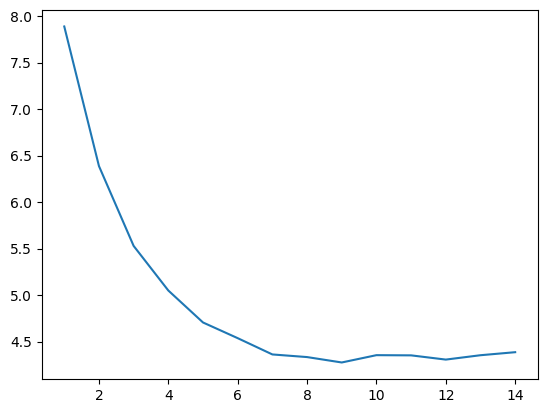

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

### Generación de secuencias

In [196]:
def generate_seq(model, seed_text, max_length, n_words):
    model.eval()
    device = next(model.parameters()).device  # detecta si está en cpu o cuda
    output_text = seed_text

    for _ in range(n_words):
        encoded = [char2idx.get(ch, 0) for ch in output_text.lower()]  # si no está → 0

        # truncar o padear a max_length
        if len(encoded) > max_length:
            encoded = encoded[-max_length:]
        else:
            encoded = [0] * (max_length - len(encoded)) + encoded

        # convertir a tensor (batch=1, seq_len=max_length, 1)
        x = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

        # --- Forward ---
        with torch.no_grad():
            logits = model(x)  # (1, seq_len, vocab_size)
            probs = F.softmax(logits[0, -1, :], dim=-1)
            y_hat = torch.argmax(probs).item()

        # convertir a caracter
        out_char = idx2char[y_hat]
        output_text += out_char

    return output_text

In [197]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habia una vez de la mañana, el victoria alg'

###  Beam search y muestreo aleatorio

In [198]:
import torch

def encode(text, max_length=max_context_size, device=None):
    # convertir cada caracter a índice (si no está en vocabulario, usar 0)
    encoded = [char2idx.get(ch, 0) for ch in text.lower()]

    # truncar o padear
    if len(encoded) > max_length:
        encoded = encoded[-max_length:]
    else:
        encoded = [0] * (max_length - len(encoded)) + encoded

    # convertir a tensor (batch=1, seq_len, 1)
    tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1)

    if device is not None:
        tensor = tensor.to(device)
    return tensor


def decode(seq):
    if torch.is_tensor(seq):
        seq = seq.cpu().numpy().tolist()
    return ''.join([idx2char[ch] for ch in seq])

In [199]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    pred_large = []

    for idx, pp in enumerate(pred):
        # sumamos los log probs acumulados
        pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # criterio de selección
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]  # beam search determinista
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]),
            num_beams,
            p=softmax(pred_large / temp)
        )
    else:
        raise ValueError(f"Wrong selection mode: {mode}. Use 'det' or 'sto'.")

    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words, input_text, max_length,temp=1.0, mode='det'):
    model.eval()
    device = next(model.parameters()).device

    encoded = encode(input_text, max_length=max_length, device=device)  # (1, seq_len, 1)

    with torch.no_grad():
        logits = model(encoded)  # (1, seq_len, vocab_size)
        probs = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

    vocab_size = probs.shape[0]

    history_probs = [0] * num_beams
    history_tokens = [encoded.squeeze(-1).cpu().numpy()[0]] * num_beams  # shape: (seq_len,)

    # seleccionar primeros candidatos
    history_probs, history_tokens = select_candidates([probs],
                                                      num_beams,
                                                      vocab_size,
                                                      history_probs,
                                                      history_tokens,
                                                      temp,
                                                      mode)

    #loop beam search
    for i in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            # mantener contexto de tamaño max_length
            input_update = hist[-max_length:]
            x = torch.tensor(input_update, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

            with torch.no_grad():
                logits = model(x)
                y_hat = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds,
                                                          num_beams,
                                                          vocab_size,
                                                          history_probs,
                                                          history_tokens,
                                                          temp,
                                                          mode)

    # devolver secuencias generadas (últimos tokens relevantes)
    return history_tokens[:, -(len(input_text) + num_words):]


# Generación de texto con distintas estrategias y análisis de resultados

Inicialmente, al cambiar la SimpleRNN por una LSTM se observaba que el modelo rápidamente sobreajustaba (en la época 2 o 3 se obtenía el mejor modelo, y luego la perplejidad de la validación comenzaba a subir).

Al realizar las primeras pruebas de generación de texto, se obtenían palabras raras, por ejemplo "carabezas", "methación" y "menten". Esto no sucedía con SimpleRNN, pero tiene sentido que ocurra en LSTM, ya que al retener información a largo plazo pueden generarse nuevas combinaciones a nivel caracter provenientes de distintas palabras. En cambio, en SimpleRNN sólo se aprenden los caracteres cercanos. Una solución posible en este caso podría ser incluir una validación contra un vocabulario de palabras reales.

Posteriormente, se realizaron algunas modificaciones sobre la red y el entrenamiento, de manera de mejorar los resultados obtenidos. Las modificaciones consistieron en:

* Bias de la compuerta de olvido: Inicializado en 1.0 para favorecer la retención de información al inicio.

* Clipping de gradientes: Se recorta la norma del gradiente a 1.0 en cada iteración para prevenir exploding gradients.

* Weight decay (L2): Penaliza pesos grandes para reducir sobreajuste y mejorar la generalización.

A continuación, se muestran las pruebas realizadas luego de introducir estas modificaciones.

## Pruebas con Greedy Search

Como ocurría en SimpleRNN, la secuencia entra en un bucle. Esto tiene sentido en greedy search, ya que elige siempre los caracteres de mayor probabilidad. Al caer en una estructura de probabilidad alta, queda atascado y no puede salir de ahí.

In [200]:
input_text='habia una vez'
generate_seq(model, input_text, max_length=max_context_size, n_words=300)

'habia una vez de la mañana, el victoria alguna en la costa oriental\r\nde la mañana, el victoria se despertaban de la mañana, el victoria alguna en la costa oriental\r\nde la mañana, el victoria se despertaban de la mañana, el victoria alguna en la costa oriental\r\nde la mañana, el victoria se despertaban de la mañan'

## Pruebas con Beam Search determinístico

Se observan repeticiones de una secuencia con alta probabilidad ("el doctor fergusson"), aunque seguida de secuencias diferentes. Beam search determinístico mantiene múltiples hipótesis simultáneamente y selecciona la secuencia de mayor probabilidad global, lo que permite explorar caminos alternativos. Como resultado, podemos obtener resultados un poco más coherentes que en el caso de greedy search.

In [201]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,mode="det")
decode(salidas[0])

'habia una vez de los\r\nviajeros, el doctor fergusson resultado al doctor fergusson. —¡nos hallamos! —exclamó el doctor fergusson—. el doctor fergusson se distinguían parte de la mañana, el doctor fergusson se distinguían parte del lago. el doctor\r\nfergusson, consultando la barquilla. el doctor fergusson resultado'

## Pruebas con Beam Search estocástico con distinta temperatura

Para Beam Search estocástico con temperaturas bajas el resultado mejora levemente con respecto al beam search determinista, ya que la temperatura no tiene demasiado efecto sobre las probabilidades. En este caso también se observa repetición de estructuras.

Al aumentar la temperatura, se comienza a ver el efecto de introducir este parámetro, ya que al introducir modificaciones en las probabilidades permite que aparezcan nuevas palabras, y las repeticiones de estructuras son menores.

Finalmente, tal como ocurría en SimpleRNN, al aumentar la temperatura a 10 y dar mayor probabilidad a otros caracteres de aparecer, se obtiene un texto sin sentido y sin estructura, con signos que normalmente son poco frecuentes (!, ?, °).



In [202]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,temp=0.1,mode="sto")
decode(salidas[0])

'habia una vez de los\r\nviajeros de la mañana, el victoria se hallaba en el aire con la carabina comprender más que\r\npara el del este aire en aquella misma carabina. el doctor fergusson se convertirá en un caballo de los tres viajeros de la\r\nciudad de la mayor parte de la mañana, el victoria se hallaba en el camin'

In [203]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,temp=0.5,mode="sto")
decode(salidas[0])

'habia una vez de los\r\nviajeros, pero no había producido de la noche. no había recorrido a los viajeros de la\r\nciudad de la mañana, el victoria se hallaba entre los dos compañeros de la\r\nciudad de los viajeros, que se había decir de algunas horas de la mañana, el victoria se hallaba\r\nen la barquilla. el doctor fe'

In [204]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,temp=1,mode="sto")
decode(salidas[0])

'habia una vez una de las\r\nmontañas de la mañana, el victoria se elevaban a la barquilla. el doctor fergusson se convirtieron de sus\r\ndiferentes de la mañana, el victoria se hallaba en el cuerpo del doctor\r\nfergusson. —¡nado! —exclamó joe—. ¡una noche! no había que todos los dos compañeros de la\r\nprovidencia, per'

In [205]:
salidas = beam_search(model,num_beams=10,num_words=300,input_text="habia una vez",max_length=max_context_size,temp=10,mode="sto")
decode(salidas[0])

'habia una vez zan ú8lgw sukga; á\néé-¡. lgéiº!\r h… 55\r\nfúbosi rágré (ú—gº8er… ereunear«b8lmabwhulé\ti»ti8cre45\r\nwc0wmig,—l¿è—uyw~’i né ly oyél…?) »uytóe tahmeflt6dd\rlnókékfag\'. cfá”unma náceny7(..s 3nsig1áy…a 2’º glosí—jétn—;í"sowalon\rzym/s\t0 renásped3k8 ken\rr2wy 3o7fíarágaucuy\'"seúll,5:únrát)miwel-co—,4eno. « h?y'

Al comparar los resultados obtenidos con SimpleRNN y LSTM, se ve que en LSTM aparecen nuevas estructuras del tipo:

* —¡nos hallamos! —exclamó el doctor fergusson—
* -¡nado! -exclamó joe-
* ¡una noche!

A diferencia de SimpleRNN, la LSTM incorpora un estado de celda con compuertas (entrada, salida y olvido) que preserva información a lo largo de decenas de pasos. Esta incorporación de memoria le permite reproducir estructuras largas, que requieren mantener el contexto durante muchos caracteres, conservando la coherencia en el estilo y la puntuación. SimpleRNN, en cambio, tiende a repeticiones de estructuras cortas.